In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras_self_attention import SeqSelfAttention
from konlpy.tag import Okt
import json
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
df = pd.read_json('1.json', encoding='utf-8')

In [4]:
df.head()

,music
0,"{'id': 1, 'title': '다시 여기 바닷가', 'release': '예아..."
1,"{'id': 2, 'title': '눈누난나 (NUNU NANA)', 'releas..."
2,"{'id': 3, 'title': '마리아 (Maria)', 'release': '..."
3,"{'id': 4, 'title': '그 여름을 틀어줘', 'release': '이 ..."
4,"{'id': 5, 'title': 'How You Like That', 'relea..."


In [5]:
df = df.iloc[:, 0]

In [6]:
title=[]
genre = []
lyrics=[]
for i in df:
    title.append(i['title'])
    cnt = i['type']
    cnt = cnt.split(',')
    genre.append(cnt[0])
    lyrics.append(i['release'])

In [7]:
df2 = pd.DataFrame({'title':title, 'genre':genre, 'lyrics':lyrics})

In [8]:
genre_list = df2['genre'].unique()

In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4537 entries, 0 to 4536
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   4537 non-null   object
 1   genre   4537 non-null   object
 2   lyrics  4537 non-null   object
dtypes: object(3)
memory usage: 106.5+ KB


In [10]:
import re
p = re.compile('[a-z]')
lyric_temp = []
temp_1 = []
temp_2 = []
for i in range(df2.shape[0]):
    # 영어 가사가 있는 노래는 완전 제외
    # if not p.search(data['lyrics'].iloc[i]) and len(data['lyrics'].iloc[i]) > 20:
        # lyric_temp.append(df2['lyrics'].iloc[i])
        
    # 영어 가사가 있는 부분을 삭제
    if len(df2['lyrics'].iloc[i]) > 20:
        lyric_temp.append(df2['lyrics'].iloc[i].replace('[a-z]+', ''))

        temp_1.append(df2['title'].iloc[i])
        temp_2.append(df2['genre'].iloc[i])

In [11]:
df2 = pd.DataFrame({'title' : temp_1, 'genre' : temp_2, 'lyrics' : lyric_temp})

In [12]:
df2['genre'].nunique()
df2['genre'] = df2['genre'].replace(df2['genre'].unique(), range(len(df2['genre'].unique())))
df2['genre'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18], dtype=int64)

In [13]:
df2

,title,genre,lyrics
0,다시 여기 바닷가,0,예아 호우 예예예싹쓰리 인더 하우스커커커커커몬 싹 쓰리 투 렛츠고나 다시 또 설레어...
1,눈누난나 (NUNU NANA),1,I’m trying to give usomething moreSo come with...
2,마리아 (Maria),0,욕을 하도 먹어 체했어 하도서러워도 어쩌겠어 I do모두들 미워하느라 애썼네날 무너...
3,그 여름을 틀어줘,0,이 여름 다시 한번 설레고 싶다그때 그 여름을 틀어줘그 여름을 들려줘그때 그 여름을...
4,How You Like That,1,보란 듯이 무너졌어바닥을 뚫고 저 지하까지옷 끝자락 잡겠다고저 높이 두 손을 뻗어봐...
...,...,...,...
4421,당신만이,3,눈부신 햇살이 비춰주어도 제게 무슨 소용있겠어요 이토록 아름다운 당신만이 나에게 빛...
4422,겁나 (Feat. 매드클라운),3,너무 살가웠던 네가언제나 다정했던 네가꼭 오늘 따라다른 사람 같아어떻게 해야 해자꾸...
4423,시간과 낙엽,3,맨발로 기억을 거닐다 떨어지는 낙엽에 그간 잊지 못한 사람들을 보낸다 맨발로 기억을...
4424,내일,2,모두가 돌아간 자리행복한 걸음으로 갈까정말 바라던 꿈들을 이룬 걸까밀렸던 숙제를 하...


In [14]:
_train, _test, y_train, y_test = train_test_split(df2['lyrics'], df2['genre'], test_size=0.25, shuffle=False)

print('# split done')

# stopwords 지정
with open('korean_stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = f.read()
stopwords = stopwords.split('\n')

# split done


In [29]:
X_train, X_test = [], []

In [30]:
# # 토큰화 진행
# for stc in _train:
#     token = []
#     words = Okt().morphs(stc, stem=True)
#     for word in words:
#         if word not in stopwords:
#             token.append(word)
#     X_train.append(token)

# for stc in _test:
#     token = []
#     words = Okt().morphs(stc, stem=True)
#     for word in words:
#         if word not in stopwords:
#             token.append(word)
#     X_test.append(token)

# print('# tokenization done')

# import pickle
# with open('X_train_test_splited.p', 'wb') as f:
#     pickle.dump(X_train, f)
#     pickle.dump(X_test, f)

# tokenization done


In [18]:
import pickle
with open('X_train_test_splited.p', 'rb') as f:
    X_train = pickle.load(f)
    X_test = pickle.load(f)

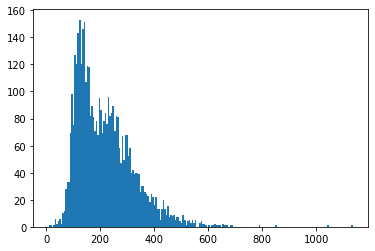

In [19]:
 import matplotlib.pyplot as plt
 a = X_train+X_test
 b=[]
 for i in a:
     b.append(len(i))
# b
 plt.hist(b, bins=200)
 plt.show()

In [20]:
# X_train 단어들을 토대로 정수 인덱스 설정, 전체 단어 갯수 설정
# 유의미한 단어? 빈도수가 1~2개인 단어 버려도 큰 영향을 끼치지 않을것 -> count함수써서 빈도수 낮은 것들을 버리고, 남은 단어의 갯수들
max_num_words = 2802
tokenizer = Tokenizer(max_num_words)
tokenizer.fit_on_texts(X_train+X_test)

# 설정된 정수 인덱스를 토대로 변환
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

print('# int_encoding done')

# int_encoding done


In [21]:
len(X_train), len(y_train), len(X_test), len(y_test), len(X_train) + len(X_test)

(3319, 3319, 1107, 1107, 4426)

In [22]:
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens')
vocab_size = len(word_index) + 1

Found 36544 unique tokens


In [23]:
# # len(sorted(y_train.unique()))
# len(sorted(y_test.unique()))
len(np.unique(np.concatenate([np.array(y_train), np.array(y_test)])))

19

In [24]:
max_length = 200
X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)

In [25]:
len(X_test[0])

200

In [26]:
import pickle
with open('lyrics_word2vec_remove_eng.p', 'rb') as f:
    vector = pickle.load(f)

In [27]:
print(vector.wv.vectors.shape)

(10702, 400)


In [28]:
embedding_matrix = np.zeros((vocab_size, 400))

print(np.shape(embedding_matrix))

(36545, 400)


In [29]:
def get_vector(word):
    if word in vector:
        return vector[word]
    else:
        return None
for word, i in word_index.items():
    temp = get_vector(word)
    if temp is not None:
        embedding_matrix[i] = temp

In [30]:
y_unique = np.unique(np.concatenate([ np.array(y_train), np.array(y_test) ]))

In [31]:
model = Sequential()
e = Embedding(vocab_size, 400, weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
# model.add(Embedding())
model.add(Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
# model.add(Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
# model.add(Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
# model.add(Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model.add(SeqSelfAttention(attention_activation='softmax'))
# model.add(SeqSelfAttention())
model.add(Flatten())
model.add(Dense(len(y_unique), activation='softmax'))

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 400)          14618000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 256)          541696    
_________________________________________________________________
seq_self_attention_1 (SeqSel (None, 200, 256)          16449     
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 19)                972819    
Total params: 16,148,964
Trainable params: 1,530,964
Non-trainable params: 14,618,000
_________________________________________________________________


In [33]:
from tensorflow.keras.optimizers import Adam
opt = Adam(0.001)

In [34]:
# from keras.optimizers import SGD
# opt = SGD(lr=0.01)

In [35]:
type(X_train)

numpy.ndarray

In [36]:
model.compile(optimizer=opt, loss = 'sparse_categorical_crossentropy', metrics=['acc'])

In [39]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=10)

Train on 3319 samples, validate on 1107 samples
Epoch 1/20
3319/3319 [==============================] - 90s 27ms/step - loss: 1.3650 - acc: 0.5592 - val_loss: 1.4642 - val_acc: 0.5330
Epoch 2/20
3319/3319 [==============================] - 88s 27ms/step - loss: 1.2586 - acc: 0.5845 - val_loss: 1.3592 - val_acc: 0.5483
Epoch 3/20
3319/3319 [==============================] - 102s 31ms/step - loss: 1.2277 - acc: 0.5936 - val_loss: 1.3941 - val_acc: 0.5510
Epoch 4/20
3319/3319 [==============================] - 114s 34ms/step - loss: 1.1930 - acc: 0.6086 - val_loss: 1.3836 - val_acc: 0.5519
Epoch 5/20
3319/3319 [==============================] - 113s 34ms/step - loss: 1.1721 - acc: 0.5978 - val_loss: 1.4159 - val_acc: 0.5339
Epoch 6/20
3319/3319 [==============================] - 112s 34ms/step - loss: 1.1543 - acc: 0.6161 - val_loss: 1.4274 - val_acc: 0.5465
Epoch 7/20
3319/3319 [==============================] - 109s 33ms/step - loss: 1.1302 - acc: 0.6146 - val_loss: 1.4133 - val_acc: 0.

In [ ]:
# model.save('./model_eng_entirely_removed', include_optimizer=False)

In [54]:
model.save('model_eng_partially_removed.h5', include_optimizer=False)

In [55]:
import tensorflow as tf
model = tf.keras.models.load_model('./model_eng_partially_removed.h5')

ValueError: Unknown layer: SeqSelfAttention

In [56]:
def model_predict(input_txt):
    # input_txt = input()

    # 영어 가사 제거
    input_txt = input_txt.replace('[a-z}+', '')

    # 토큰화
    tokens = Okt().morphs(input_txt, stem=True)

    # 불용어 제거
    tmp = []
    for word in tokens:
        if word not in stopwords:
            tmp.append(word)
    tokens=tmp.copy()
    del(tmp)

    token_seq = tokenizer.texts_to_sequences([tokens])
    padded_seq = pad_sequences(token_seq, padding='post', maxlen=max_length)

    predict_result = model.predict(padded_seq)
    predict_result = np.round(predict_result[0], 2)

    return predict_result

def show_genre(predict_result, show_prob=False):
    if show_prob:
        print("==장르당 확률==")
        for i in range(len(predict_result)):
            print(f"{genre_list[i]} : ", end='')
            print(predict_result[i])
    # print(f"\n최종 예측 결과 : {genre_list[predict_result.argmax()]}")
    return genre_list[predict_result.argmax()]

In [58]:
# genre_list[df2['genre']]

predicted_list = []
for i in range(df2.shape[0]):
# for i in range(10):
    if i % 500 == 0:
        print(f"Count : {i}")
    predict = model_predict( df2['lyrics'].iloc[i] )
    predicted_list.append(show_genre(predict))

predicted_table = pd.DataFrame({ 'title' : df2['title'], 'predicted':predicted_list, 'actual' : genre_list[df2['genre']] })

Count : 0
Count : 500
Count : 1000
Count : 1500
Count : 2000
Count : 2500
Count : 3000
Count : 3500
Count : 4000


In [59]:
predicted_table

,title,predicted,actual
0,다시 여기 바닷가,댄스,댄스
1,눈누난나 (NUNU NANA),랩/힙합,랩/힙합
2,마리아 (Maria),댄스,댄스
3,그 여름을 틀어줘,댄스,댄스
4,How You Like That,랩/힙합,랩/힙합
...,...,...,...
4421,당신만이,발라드,발라드
4422,겁나 (Feat. 매드클라운),댄스,발라드
4423,시간과 낙엽,발라드,발라드
4424,내일,발라드,록/메탈


In [60]:
with open('predicted_table.p', 'wb') as f:
    pickle.dump(predicted_table, f)